# Les économistes de DBPedia – Introduction


Cet ensemble de carnets a pour finalité d'analyser les principales propriétés des personnes identifiées comme économistes dans DBPedia en anglais. Cf. par exemple les données relatives à [John Maynard Keynes](https://dbpedia.org/page/John_Maynard_Keynes).

La finalité de l'analyse est non seulement de cerner le profil de cette population à partir des propriétés disponibles dans DBPedia mais surtout d'illustrer le potentiel de différentes techniques d'exploration et d'analyse de données. 

La source des données est représentée par DBPedia et donc, par son intermédiaire, par Wikipedia qui est la source principale de ces données extraites automatiquement des '[Infobox](https://en.wikipedia.org/wiki/Infobox)' et textes de l'encyclopédie collaborative. Les données sont récupérées grâce à des requêtes SPARQL exécutées sur le point d'accès SPARQL de DBPedia : https://dbpedia.org/sparql.


Dans le carnet [dbpedia_exploration.ipynb](dbpedia_exploration.ipynb) on procède à l'analyse des manières d'identifier la population des économistes, puis à l'exploration des propriétés disponibles. Les requêtes sont stockées dans une base de données SQLite afin de pouvoir les gérer facilement et ajouter des annotations qui les concernent. 


Les requêtes 19 et 8 de la base de données permettent d'identifier 6868 personnes en tant qu'économistes (résultat au 7 mai 2021) et de lister et compter leurs propriétés. Parmi celles-ci les plus fréquentes ou les plus significatives, comme nationalité, ou Université fréquentée, etc. ont été retenues et stockées dans une table dédiée de la base de données SQLite afin de pouvoir être analysées. Le processus de production est documenté dans le carnet [dbpedia_production.ipynb](dbpedia_production.ipynb).

Ci-dessous on trouvera une exploration des propriétés qui ont été retenues et des considérations concernant leur analyse qui renvoient également aux autres carnets réalisés.



### Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time
import statistics as stat

from importlib import reload
from shutil import copyfile

## Base de données

In [5]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [7]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20210522_224233'

In [8]:
##  Préparation du nom de la copie
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [9]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210522_224233.sqlite'

## Préparation des propriétés des personnes qui ont été extraites de DBPedia

Étant donné que la dimension diachronique est essentielle dans les sciences historiques, l'analyse sera restreinte aux personnes qui disposent d'une année de naissance, afin de pouvoir les situer sur l'échelle du temps.

Le nettoyage et la production d'une propriété 'année de naissance' sont documentés dans ce carnet [dbpedia_production.ipynb](dbpedia_production.ipynb), en bas: "Ajout des années de naissance nettoyées".

Sont retenues ici les principales propriétés stockées dans la base de données pour les personnes nées en 1771 et après, actives donc à partir de la Révolution française et des guerres qui se sont suivies et ont changé la carte de l'Europe, en marquant la transition vers l'époque contemporaine.

* Nombre de personnes dans la base de données : 6868 

<code> WITH tw1 AS (SELECT DISTINCT uri_entity 
FROM entity
WHERE entity_class = 'https://dbpedia.org/ontology/Person')
SELECT count(*) FROM tw1;
</code>

* Nombre de personnes avec une années de naissance : 3849

<code>SELECT COUNT(*)
FROM (
SELECT DISTINCT uri_entity
FROM property
WHERE property LIKE '%ontology/birthYear' );
</code>




In [459]:
### Requête qui regroupe toutes les propriétés qu'on souhaite analyser et comparer
#  Ajouter des sous-requêtes pour chacune des propriétés, regrouper dans le GROUP BY final
##  La clause LEFT JOIN permet d'obtenir les résultats disponibles pour chaque propriété et personne, 
# tout en laissant la valeur vide pour les personnes qui n'ont pas telle propriété
# Restriction sur la période, nés en 1771 et après

personnes_proprietes = """
WITH tw1 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END field
FROM property
WHERE property IN ('http://dbpedia.org/property/field', 'http://dbpedia.org/ontology/field')
),
tw2 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END nationality
FROM property
WHERE property IN ('http://dbpedia.org/property/nationality', 'http://dbpedia.org/ontology/nationality')
),
tw3 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END birth_place
FROM property
WHERE property IN ('http://dbpedia.org/ontology/birthPlace')
),
tw4 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END alma_mater
FROM property
WHERE property IN ('http://dbpedia.org/ontology/almaMater')
),
tw5 AS(
-- attention : propriété inversée ! La personne est l'influencé
SELECT DISTINCT  value,
CASE WHEN value like 'http%'
then replace(uri_entity, 'http://dbpedia.org/resource/', '')
else value END influenced_by
FROM property
WHERE property IN ('http://dbpedia.org/ontology/influenced')
),
tw6 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END institution
FROM property
WHERE property IN ('http://dbpedia.org/ontology/institution')
),
tw7 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END occupation
FROM property
WHERE property IN ('http://dbpedia.org/property/occupation', 'http://dbpedia.org/ontology/occupation')
)
SELECT p.uri_entity, 
        -- en cas d'années de naissance multiples la moyenne arrontie à l'entier est retenue
        CAST(ROUND(SUM(p.value)/COUNT(*)) AS INT) annee, 
        GROUP_CONCAT(DISTINCT(tw1.field)) field, 
        GROUP_CONCAT(DISTINCT(tw2.nationality)) nationality,
        GROUP_CONCAT(DISTINCT(tw3.birth_place)) birth_place,
        GROUP_CONCAT(DISTINCT(tw4.alma_mater)) alma_mater,
        GROUP_CONCAT(DISTINCT(tw5.influenced_by)) influenced_by,
        GROUP_CONCAT(DISTINCT(tw6.institution)) institution,
        GROUP_CONCAT(DISTINCT(tw7.occupation)) occupation
FROM property p 
    LEFT JOIN tw1 ON tw1.uri_entity = p.uri_entity
    LEFT JOIN tw2 ON tw2.uri_entity = p.uri_entity
    LEFT JOIN tw3 ON tw3.uri_entity = p.uri_entity
    LEFT JOIN tw4 ON tw4.uri_entity = p.uri_entity
    LEFT JOIN tw5 ON tw5.value = p.uri_entity
    LEFT JOIN tw6 ON tw6.uri_entity = p.uri_entity
    LEFT JOIN tw7 ON tw7.uri_entity = p.uri_entity    
WHERE p.property LIKE '%ontology/birthYear'
GROUP BY p.uri_entity
HAVING annee > 1770
ORDER BY annee;
"""

In [463]:
### Produire un DataFrame à partir de la requête SQL ci-dessus

cn = sql.connect(db)
personnes = pd.read_sql_query(personnes_proprietes, cn)
cn.close()

## Effectif des personnes = nombre de lignes dans le DataFrame
print(len(personnes))

##  Inspecter le DataFrame, deux méthodes: iloc (un certain nombre de lignes indiqué par l'index) ou head() 
personnes.iloc[310:315,]
# personnes.head(40)

3779


,uri_entity,annee,field,nationality,birth_place,alma_mater,influenced_by,institution,occupation
310,http://dbpedia.org/resource/Arrigo_Serpieri,1877,None,Italy,Bologna,None,None,None,"Arrigo_Serpieri__PersonFunction__1,Lecturer"
311,http://dbpedia.org/resource/Arthur_Cecil_Pigou,1877,Welfare_economics,Britain,"Isle_of_Wight,Ryde","King's_College,_Cambridge","Alfred_Marshall,Henry_Sidgwick",University_of_Cambridge,None
312,http://dbpedia.org/resource/D._H._MacGregor,1877,None,"Scotland,Scottish",Monifieth,None,None,None,"D._H._MacGregor__PersonFunction__1,economist"
313,http://dbpedia.org/resource/Farkas_Heller,1877,"Economist,Statistician",Hungarians,"Budapest,Kingdom_of_Hungary",Budapest_University_of_Technology_and_Economics,None,Budapest_University_of_Technology_and_Economics,None
314,http://dbpedia.org/resource/Hjalmar_Schacht,1877,None,German,"German_Empire,Province_of_Schleswig-Holstein,T...",None,None,None,None


In [464]:
## Colonnes dans le tableau
list(personnes.columns)

['uri_entity',
 'annee',
 'field',
 'nationality',
 'birth_place',
 'alma_mater',
 'influenced_by',
 'institution',
 'occupation']

In [465]:
## Mettre 'uri_entity' comme index, créer un nom lisible

personnes['uri_entity'] = personnes['uri_entity'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
personnes['name'] = personnes['uri_entity'].apply(lambda x : x.replace('_', ' '))
personnes.set_index('uri_entity', inplace=True, verify_integrity=True)
personnes.head()

,annee,field,nationality,birth_place,alma_mater,influenced_by,institution,occupation,name
uri_entity,,,,,,,,,
Philipp_Emanuel_von_Fellenberg,1771,None,None,"Bern,Switzerland",University_of_Tübingen,None,None,"Agronomist,Educationalist,Educationalist and a...",Philipp Emanuel von Fellenberg
Charles_Fourier,1772,None,None,Besançon,None,"Nicolas-Edme_Rétif,Victor_Prosper_Considerant",None,None,Charles Fourier
David_Ricardo,1772,None,British,None,None,None,None,None,David Ricardo
Jacob_Aall,1773,None,Norway,Porsgrunn,None,None,None,"Economist,Historian,Landowner,Politician,state...",Jacob Aall
James_Mill,1773,None,None,"Angus,_Scotland",None,"David_Hartley_(philosopher),Dugald_Stewart,Jer...",None,None,James Mill


In [466]:
###  Les colonnes des valeurs contiennent des listes (car une personne peut avoir plusieurs métiers) :
##  compter les effectifs de chaque cellule adjacente

personnes['len_field'] = personnes['field'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_nationality'] = personnes['nationality'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_birth_place'] = personnes['birth_place'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_alma_mater'] = personnes['alma_mater'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_influenced_by'] = personnes['influenced_by'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_institution'] = personnes['institution'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_occupation'] = personnes['occupation'].apply(lambda x : len(x.split(',')) if x else 0)

In [467]:
### Changer l'ordre des colonnes pour les mettre dans un ordre suivant le cursus de la personne

personnes = personnes[['name', 'annee', 'nationality', 'len_nationality','birth_place','len_birth_place', \
                       'alma_mater', 'len_alma_mater', 'influenced_by', 'len_influenced_by', 'field', 'len_field',\
                       'occupation', 'len_occupation', 'institution', 'len_institution']]
personnes.iloc[140:145]

,name,annee,nationality,len_nationality,birth_place,len_birth_place,alma_mater,len_alma_mater,influenced_by,len_influenced_by,field,len_field,occupation,len_occupation,institution,len_institution
uri_entity,,,,,,,,,,,,,,,,
Giuseppe_Toniolo,Giuseppe Toniolo,1845,None,0,"Kingdom_of_Lombardy-Venetia,Treviso",2,None,0,None,0,None,0,None,0,None,0
Theodor_Hertzka,Theodor Hertzka,1845,"Austrians,Hungarian_people,Hungarians",3,"Budapest,Kingdom_of_Hungary",2,None,0,None,0,"Monetary_economics,Monetary_theory",2,None,0,None,0
Pieter_Cort_van_der_Linden,Pieter Cort van der Linden,1846,Netherlands,1,"Netherlands,The_Hague",2,"Bachelor_of_Laws,Doctor_of_Philosophy,Leiden_U...",4,None,0,None,0,"Academic_administration,Author,Civil_service,E...",11,None,0
Charles_Gide,Charles Gide,1847,French,1,Uzès,1,None,0,None,0,"History_of_economic_thought,Social_economy,The...",3,None,0,None,0
Ebbe_Hertzberg,Ebbe Hertzberg,1847,Norwegian,1,Holmestrand,1,None,0,None,0,None,0,"Ebbe_Hertzberg__PersonFunction__1,Legal_histor...",3,None,0


## Distribution des propriétés disponibles

Pour chaque personne de la population on va vérifier si une propriété est renseignée ou non. Une propriété peut être renseignée plusieurs fois pour chaque personne (par ex. on peut avoir fréquenté plusieurs Universités) mais elle est comptée une seule fois.

Cette méthode permet d'avoir un aperçu des propriétés disponibles et ensuite de décider ce qui pourra être analysé.


In [ ]:
## Méthode utilisée pour parcourir les données du tableau
list(personnes.iterrows())[:1]

In [357]:
eff_personnes = 0
nationality = 0
birth_place = 0
alma_mater = 0
influenced_by = 0
field = 0
occupation = 0
institution = 0
for i,r in list(personnes.iterrows()):
    eff_personnes += 1
    if r['len_nationality'] > 0:        
        nationality += 1
    if r['len_birth_place'] > 0:
        birth_place += 1
    if r['len_alma_mater'] > 0:
        alma_mater += 1
    if r['len_influenced_by'] > 0:
        influenced_by += 1
    if r['len_field'] > 0:
        field += 1
    if r['len_occupation'] > 0:
        occupation += 1
    if r['len_institution'] > 0:
        institution += 1

In [358]:
effectifs_proprietes = pd.Series({"eff_personnes": eff_personnes, "nationality": nationality, "birth_place":birth_place, "alma_mater":alma_mater,\
                                  "influenced_by":influenced_by, "field":field, "occupation":occupation, "institution":institution })
effectifs_proprietes

eff_personnes    3779
nationality      2169
birth_place      3070
alma_mater       2283
influenced_by     599
field            1042
occupation        928
institution       881
dtype: int64

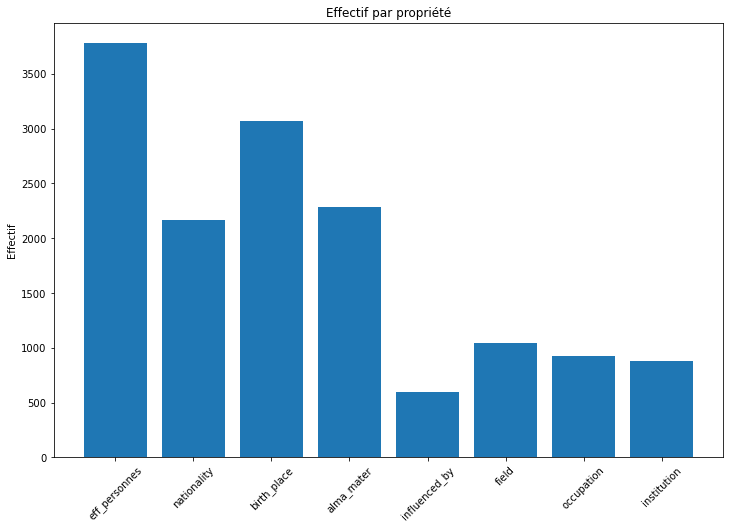

In [359]:
# Distribution par année

objects = [l for l in effectifs_proprietes.index]
eff = [l for l in effectifs_proprietes]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Effectif par propriété')
plt.gcf().set_size_inches(12, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [409]:
variables_observees = {"alma_mater":"len_alma_mater", "nationality":"len_nationality", "field":"len_field", "occupation":"len_occupation", "institution":"len_institution", }
for i,v in variables_observees.items():
    print(i,v)

alma_mater len_alma_mater
nationality len_nationality
field len_field
occupation len_occupation
institution len_institution


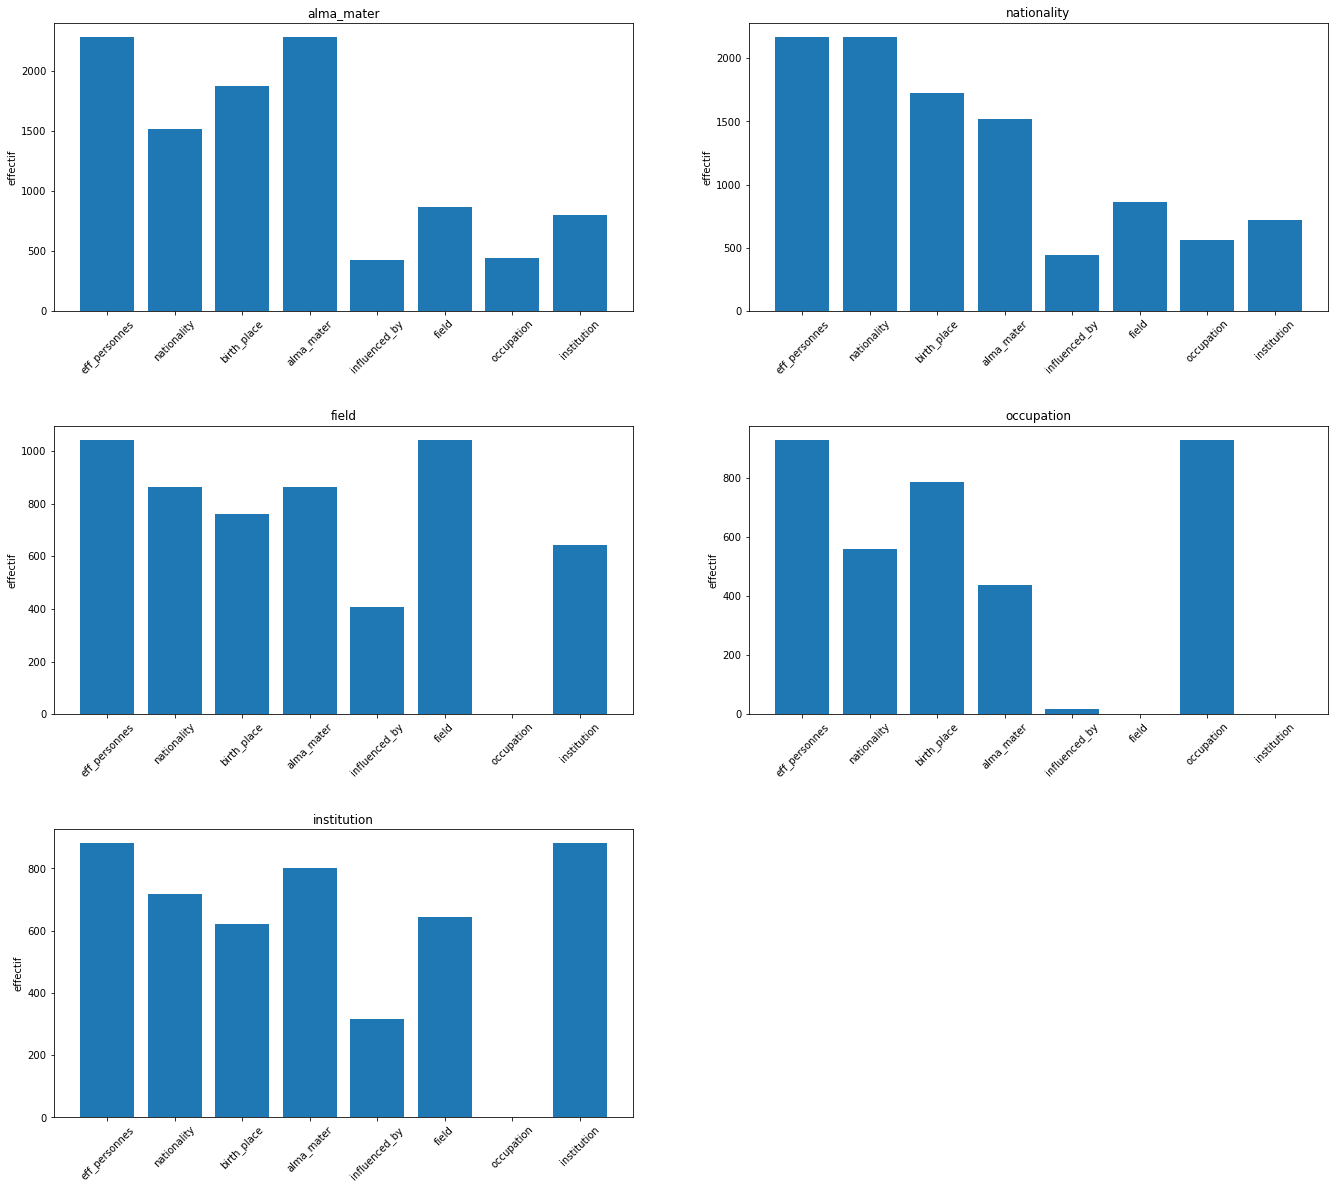

In [511]:
### Documenttaion:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplot.html
# https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/

#fig = plt.figure()
#fig.supxlabel('Comparatif de ' + ', '.join([ix for ix,v in variables_observees.items()]), fontsize=20, va='top')   

plot_id = 1
plot_left = 1
for ix,v in variables_observees.items():
    
    #print(ix,v)

    eff_personnes = 0
    nationality = 0
    birth_place = 0
    alma_mater = 0
    influenced_by = 0
    field = 0
    occupation = 0
    institution = 0
    for i,r in list(personnes.iterrows()):
        # ce filtre, qui prend par ex. la forme " r['len_occupation'] > 0 ",
        # vérifie qu'une propriété (par ex. occupation) est renseignée et calcule ensuite 
        # quelles autres propriétés sont renseignées
        if r[v] > 0:
            eff_personnes += 1
            if r['len_nationality'] > 0:        
                nationality += 1
            if r['len_birth_place'] > 0:
                birth_place += 1
            if r['len_alma_mater'] > 0:
                alma_mater += 1
            if r['len_influenced_by'] > 0:
                influenced_by += 1
            if r['len_field'] > 0:
                field += 1
            if r['len_occupation'] > 0:
                occupation += 1
            if r['len_institution'] > 0:
                institution += 1
    effectifs_proprietes = pd.Series({"eff_personnes": eff_personnes, "nationality": nationality, "birth_place":birth_place, "alma_mater":alma_mater,\
                                  "influenced_by":influenced_by, "field":field, "occupation":occupation, "institution":institution })

    x = [l for l in effectifs_proprietes.index]
    y = [l for l in effectifs_proprietes]
    
 
    plt.subplot(3, 2, plot_id)

    plt.title(ix)
    
    plt.bar(x, y)
    plt.gcf().set_size_inches(12, 8)
    plt.xticks(rotation=45)

    plt.ylabel('effectif')

    
    plot_id += 1
    

plt.subplots_adjust(#left=0.1,
                   bottom=0.1, 
                   right=1.6, 
                   top=2, 
                   # wspace=0.4, 
                   hspace=0.4
                   )

plt.show()    

# Considérations générales et analyses proposées







## Variables à analyser séparément


Lieux de naissance -> carte


# Filtrages

Le filtrage ci-dessus concernait une propriété à la foix. Ici on vérifier les propriétés disponibles pour les personnes dont 'field', 'institution' et nationality' sont renseignés

In [411]:
eff_personnes = 0
nationality = 0
birth_place = 0
alma_mater = 0
influenced_by = 0
field = 0
occupation = 0
institution = 0
for i,r in list(personnes.iterrows()):
    # if r['len_institution'] > 0:
    # if r['len_occupation'] > 0:
    if r['len_field'] > 0 and r['len_institution'] > 0 and r['len_nationality'] > 0:
    # if r['len_field'] > 0 and r['len_nationality'] > 0:
        eff_personnes += 1
        if r['len_nationality'] > 0:        
            nationality += 1
        if r['len_birth_place'] > 0:
            birth_place += 1
        if r['len_alma_mater'] > 0:
            alma_mater += 1
        if r['len_influenced_by'] > 0:
            influenced_by += 1
        if r['len_field'] > 0:
            field += 1
        if r['len_occupation'] > 0:
            occupation += 1
        if r['len_institution'] > 0:
            institution += 1
            
            
effectifs_proprietes_filtre = pd.Series({"eff_personnes": eff_personnes, "nationality": nationality, "birth_place":birth_place, "alma_mater":alma_mater,\
                                  "influenced_by":influenced_by, "field":field, "occupation":occupation, "institution":institution })
effectifs_proprietes_filtre            

eff_personnes    543
nationality      543
birth_place      382
alma_mater       506
influenced_by    223
field            543
occupation         0
institution      543
dtype: int64

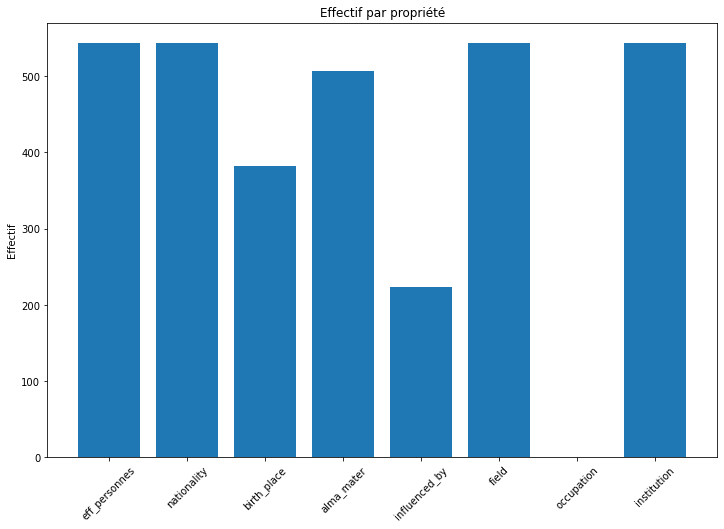

In [412]:
# Distribution par année

objects = [l for l in effectifs_proprietes_filtre.index]
eff = [l for l in effectifs_proprietes_filtre]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Effectif par propriété')
plt.gcf().set_size_inches(12, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [470]:
proprietes_personnes = []
for i,r in list(personnes.iterrows()):
    properties = []    
    if r['len_birth_place'] > 0:
        properties.append('birth_place')
    if r['len_nationality'] > 0:        
        properties.append('nationality')
    if r['len_alma_mater'] > 0:
        properties.append('alma_mater')
    if r['len_influenced_by'] > 0:
        properties.append('influenced_by')
    if r['len_field'] > 0:
        properties.append('field')
    if r['len_occupation'] > 0:
        properties.append('occupation')
    if r['len_institution'] > 0:
        properties.append('institution')
            
    proprietes_personnes.append([i, properties, len(properties)])        

    
proprietes_personnes[10:15]

[['William_Thompson_(philosopher)', ['birth_place', 'influenced_by'], 2],
 ['José_María_del_Castillo_y_Rada', ['birth_place'], 1],
 ['Francis_Horner', ['birth_place', 'alma_mater', 'occupation'], 3],
 ['Franciszek_Ksawery_Drucki-Lubecki', [], 0],
 ['Robert_Torrens_(economist)',
  ['birth_place', 'nationality', 'occupation'],
  3]]

In [471]:
df_proprietes_personnes = pd.DataFrame(proprietes_personnes, columns=['uri_personne', 'proprietes', 'effectif'])
df_proprietes_personnes.head()

,uri_personne,proprietes,effectif
0,Philipp_Emanuel_von_Fellenberg,"[birth_place, alma_mater, occupation]",3
1,Charles_Fourier,"[birth_place, influenced_by]",2
2,David_Ricardo,[nationality],1
3,Jacob_Aall,"[birth_place, nationality, occupation]",3
4,James_Mill,"[birth_place, influenced_by]",2


In [472]:
effectifs_proprietes_par_personne = df_proprietes_personnes.groupby('effectif').count()
effectifs_proprietes_par_personne

,uri_personne,proprietes
effectif,,
0,81,81
1,593,593
2,895,895
3,957,957
4,709,709
5,382,382
6,162,162


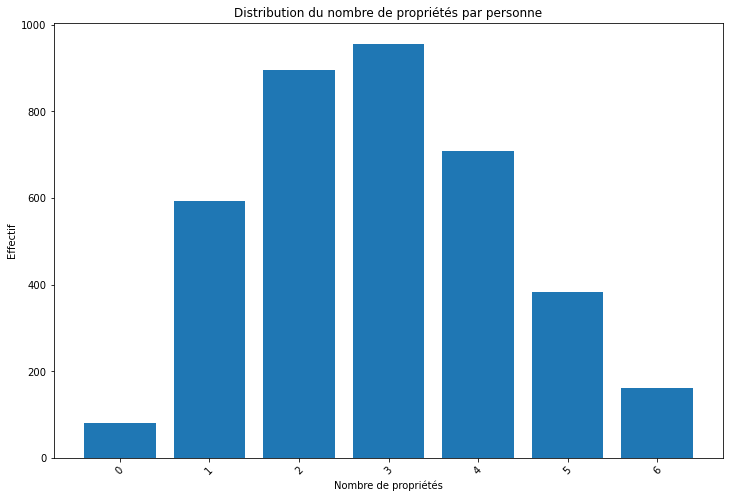

In [475]:
# Distribution par année

objects = [l for l in effectifs_proprietes_par_personne.index]
eff = [l for l in effectifs_proprietes_par_personne['proprietes']]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Nombre de propriétés')
plt.title('Distribution du nombre de propriétés par personne')
plt.gcf().set_size_inches(12, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


### Combinaisons de propriétés

In [432]:
sr_properties_groups = df_proprietes_personnes['proprietes'].groupby(df_proprietes_personnes['proprietes'].apply(lambda x : ' | '.join(x) )).count().sort_values(ascending=False)
sr_properties_groups.iloc[:30]

proprietes
birth_place                                                                     445
birth_place | alma_mater                                                        368
birth_place | nationality | alma_mater                                          295
birth_place | nationality | alma_mater | occupation                             264
birth_place | nationality | occupation                                          212
birth_place | nationality | alma_mater | field | institution                    198
birth_place | occupation                                                        171
birth_place | nationality | alma_mater | influenced_by | field | institution    162
birth_place | nationality                                                       149
birth_place | alma_mater | occupation                                           122
birth_place | nationality | alma_mater | field                                  105
nationality | alma_mater | field | institution                   

In [437]:
proprietes_personnes_filtered = []
for i,r in list(personnes.iterrows()):
    
    ### Filtre:
    
    if r['len_field'] > 0 and r['len_institution'] > 0 and r['len_nationality'] > 0: 
    
        properties = []    
        if r['len_birth_place'] > 0:
            properties.append('birth_place')
        if r['len_nationality'] > 0:        
            properties.append('nationality')
        if r['len_alma_mater'] > 0:
            properties.append('alma_mater')
        if r['len_influenced_by'] > 0:
            properties.append('influenced_by')
        if r['len_field'] > 0:
            properties.append('field')
        if r['len_occupation'] > 0:
            properties.append('occupation')
        if r['len_institution'] > 0:
            properties.append('institution')

        proprietes_personnes_filtered.append([i, properties, len(properties)])        

print(len(proprietes_personnes_filtered))    
proprietes_personnes_filtered[10:15]

543


[['Arthur_Cecil_Pigou',
  ['birth_place',
   'nationality',
   'alma_mater',
   'influenced_by',
   'field',
   'institution'],
  6],
 ['Farkas_Heller',
  ['birth_place', 'nationality', 'alma_mater', 'field', 'institution'],
  5],
 ['Paul_Nystrom',
  ['birth_place', 'nationality', 'alma_mater', 'field', 'institution'],
  5],
 ['C._H._Douglas',
  ['birth_place', 'nationality', 'alma_mater', 'field', 'institution'],
  5],
 ['Harry_Gunnison_Brown',
  ['birth_place',
   'nationality',
   'alma_mater',
   'influenced_by',
   'field',
   'institution'],
  6]]

In [442]:
df_proprietes_personnes_filtered = pd.DataFrame(proprietes_personnes_filtered, columns=['uri_entity', 'proprietes', 'effectif'])
df_proprietes_personnes_filtered.head()

,uri_entity,proprietes,effectif
0,Franz_Hermann_Schulze-Delitzsch,"[birth_place, nationality, alma_mater, influen...",6
1,Lorenz_von_Stein,"[birth_place, nationality, alma_mater, influen...",6
2,Edward_Atkinson_(activist),"[birth_place, nationality, alma_mater, influen...",6
3,Arthur_Latham_Perry,"[birth_place, nationality, alma_mater, field, ...",5
4,Georg_Friedrich_Knapp,"[birth_place, nationality, influenced_by, fiel...",5


In [445]:
merged = pd.merge(df_proprietes_personnes_filtered,personnes, on='uri_entity', sort=False)
print(len(merged))
merged.sort_values(by=['annee']).loc[30:35,]

543


,uri_entity,proprietes,effectif,name,annee,nationality,len_nationality,birth_place,len_birth_place,alma_mater,len_alma_mater,influenced_by,len_influenced_by,field,len_field,occupation,len_occupation,institution,len_institution
30,Simon_Kuznets,"[birth_place, nationality, alma_mater, field, ...",5,Simon Kuznets,1901,United_States,1,"Pinsk,Russian_Empire",2,"Columbia_University,Kharkiv_National_Universit...",2,None,0,"Development_economics,Econometrics",2,None,0,"Columbia_University,Harvard_University,Johns_H...",5
31,Theodore_Schultz,"[birth_place, nationality, alma_mater, field, ...",5,Theodore Schultz,1902,American,1,"Arlington,_South_Dakota",2,"South_Dakota_State_University,University_of_Wi...",2,None,0,Agricultural_economics,1,None,0,"Iowa_State_University,University_of_Chicago",2
32,Tord_Palander,"[birth_place, nationality, alma_mater, field, ...",5,Tord Palander,1902,Sweden,1,"Stockholm,Sweden",2,Stockholm_University,1,None,0,"Regional_science,Urban_economics",2,None,0,"University_of_Gothenburg,University_of_Uppsala",2
33,Alexander_Gerschenkron,"[birth_place, nationality, alma_mater, influen...",6,Alexander Gerschenkron,1904,United_States,1,"Odessa,Russian_Empire",2,University_of_Vienna,1,Max_Weber,1,Economic_history,1,None,0,Harvard_University,1
34,Evan_Durbin,"[birth_place, nationality, influenced_by, fiel...",5,Evan Durbin,1906,British,1,Bideford,1,None,0,"G._D._H._Cole,James_Meade,John_Bowlby,Lionel_R...",7,Macroeconomics,1,None,0,London_School_of_Economics,1
35,James_Meade,"[birth_place, nationality, alma_mater, influen...",6,James Meade,1907,British_people,1,"England,Swanage",2,"Christ's_College,_Cambridge,Malvern_College,Or...",5,John_Maynard_Keynes,1,Macroeconomics,1,None,0,London_School_of_Economics,1


In [446]:
min(merged['annee']),max(merged['annee'])

(1808, 1984)

In [447]:
y20_list = pd.RangeIndex(start=1801, stop=1990, step=20).to_list()
y20_list

[1801, 1821, 1841, 1861, 1881, 1901, 1921, 1941, 1961, 1981]

In [448]:
### coder les années les regroupant par périodes de vingt ans
merged['generation'] = pd.cut(merged['annee'], y20_list, right=False)
merged['generation'] = merged['generation'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
merged['generation'].head()

,uri_entity,proprietes,effectif,name,annee,nationality,len_nationality,birth_place,len_birth_place,alma_mater,len_alma_mater,influenced_by,len_influenced_by,field,len_field,occupation,len_occupation,institution,len_institution,generation
0,Franz_Hermann_Schulze-Delitzsch,"[birth_place, nationality, alma_mater, influen...",6,Franz Hermann Schulze-Delitzsch,1808,German_nationality_law,1,"Delitzsch,Kingdom_of_Saxony",2,"Heidelberg_University,Leipzig_University",2,"Ferdinand_Lassalle,Friedrich_Wilhelm_Raiffeisen",2,"Microeconomics,Microfinance",2,None,0,"Prussian_National_Assembly,Reichstag_(German_E...",2,1801-1821
1,Lorenz_von_Stein,"[birth_place, nationality, alma_mater, influen...",6,Lorenz von Stein,1815,German_Empire,1,"Denmark,Duchy_of_Schleswig,Eckernförde",3,University_of_Kiel,1,"Benjamin_Constant,Charles_Fourier,G._W._F._Heg...",8,"Political_economics,Political_economy",2,None,0,University_of_Vienna,1,1801-1821
2,Edward_Atkinson_(activist),"[birth_place, nationality, alma_mater, influen...",6,Edward Atkinson (activist),1827,United_States_nationality_law,1,"Brookline,_Massachusetts,Massachusetts",3,"Dartmouth_College,University_of_South_Carolina",2,"Adam_Smith,Frédéric_Bastiat,John_Bright,Richar...",4,"Economics, politics",2,None,0,"American_Academy_of_Arts_and_Sciences,American...",2,1821-1841
3,Arthur_Latham_Perry,"[birth_place, nationality, alma_mater, field, ...",5,Arthur Latham Perry,1830,United States,1,"Lyme,_New_Hampshire",2,Williams_College,1,None,0,Macroeconomics,1,None,0,Williams_College,1,1821-1841
4,Georg_Friedrich_Knapp,"[birth_place, nationality, influenced_by, fiel...",5,Georg Friedrich Knapp,1842,"German,Germany",2,"Gießen,Grand_Duchy_of_Hesse",2,None,0,Ferdinand_Lassalle,1,"Monetary_economics,Statistics",2,None,0,University_of_Strasbourg,1,1841-1861


In [455]:
y10_list = pd.RangeIndex(start=1801, stop=1990, step=10).to_list()
y10_list[-5:]

[1941, 1951, 1961, 1971, 1981]

In [456]:
### coder les années les regroupant par périodes de vingt ans
merged['decades'] = pd.cut(merged['annee'], y10_list, right=False)
merged['decades'] = merged['decades'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
merged.head()

,uri_entity,proprietes,effectif,name,annee,nationality,len_nationality,birth_place,len_birth_place,alma_mater,...,influenced_by,len_influenced_by,field,len_field,occupation,len_occupation,institution,len_institution,generation,decades
0,Franz_Hermann_Schulze-Delitzsch,"[birth_place, nationality, alma_mater, influen...",6,Franz Hermann Schulze-Delitzsch,1808,German_nationality_law,1,"Delitzsch,Kingdom_of_Saxony",2,"Heidelberg_University,Leipzig_University",...,"Ferdinand_Lassalle,Friedrich_Wilhelm_Raiffeisen",2,"Microeconomics,Microfinance",2,None,0,"Prussian_National_Assembly,Reichstag_(German_E...",2,1801-1821,1801-1811
1,Lorenz_von_Stein,"[birth_place, nationality, alma_mater, influen...",6,Lorenz von Stein,1815,German_Empire,1,"Denmark,Duchy_of_Schleswig,Eckernförde",3,University_of_Kiel,...,"Benjamin_Constant,Charles_Fourier,G._W._F._Heg...",8,"Political_economics,Political_economy",2,None,0,University_of_Vienna,1,1801-1821,1811-1821
2,Edward_Atkinson_(activist),"[birth_place, nationality, alma_mater, influen...",6,Edward Atkinson (activist),1827,United_States_nationality_law,1,"Brookline,_Massachusetts,Massachusetts",3,"Dartmouth_College,University_of_South_Carolina",...,"Adam_Smith,Frédéric_Bastiat,John_Bright,Richar...",4,"Economics, politics",2,None,0,"American_Academy_of_Arts_and_Sciences,American...",2,1821-1841,1821-1831
3,Arthur_Latham_Perry,"[birth_place, nationality, alma_mater, field, ...",5,Arthur Latham Perry,1830,United States,1,"Lyme,_New_Hampshire",2,Williams_College,...,None,0,Macroeconomics,1,None,0,Williams_College,1,1821-1841,1821-1831
4,Georg_Friedrich_Knapp,"[birth_place, nationality, influenced_by, fiel...",5,Georg Friedrich Knapp,1842,"German,Germany",2,"Gießen,Grand_Duchy_of_Hesse",2,None,...,Ferdinand_Lassalle,1,"Monetary_economics,Statistics",2,None,0,University_of_Strasbourg,1,1841-1861,1841-1851


In [451]:
### Regrouper par continent et compter avec la fonction Pandas 'groupby'
gb_generation = merged.groupby('generation').size()
gb_generation

generation
1801-1821      2
1821-1841      2
1841-1861      1
1861-1881     10
1881-1901     15
1901-1921     36
1921-1941    132
1941-1961    243
1961-1981    100
dtype: int64

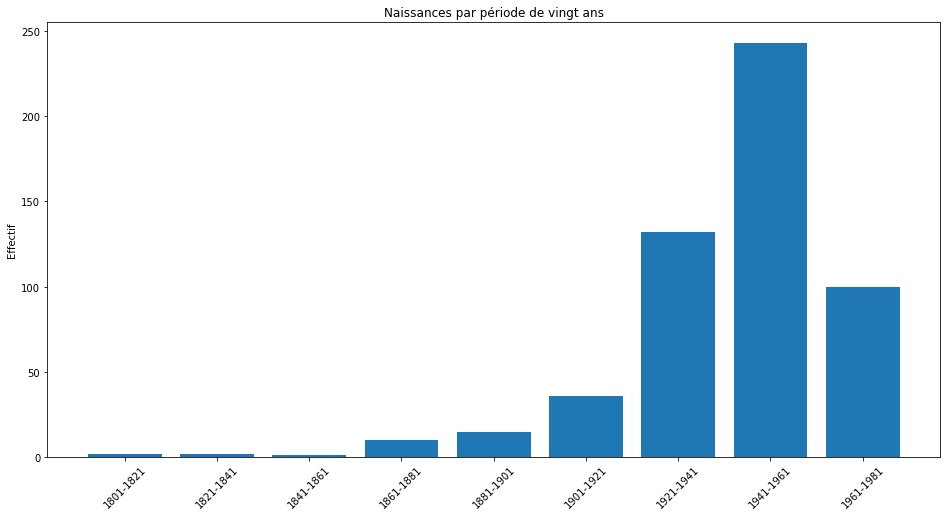

In [453]:
# Distribution par période de 10 ans de la population délimitée

objects = [l for l in gb_generation.index]
eff = [l for l in gb_generation]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingt ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [457]:
### Regrouper par continent et compter avec la fonction Pandas 'groupby'
gb_decades = merged.groupby('decades').size()
gb_decades

decades
1801-1811      1
1811-1821      1
1821-1831      2
1831-1841      0
1841-1851      1
1851-1861      0
1861-1871      3
1871-1881      7
1881-1891      7
1891-1901      8
1901-1911     12
1911-1921     24
1921-1931     58
1931-1941     74
1941-1951    117
1951-1961    126
1961-1971     72
1971-1981     28
dtype: int64

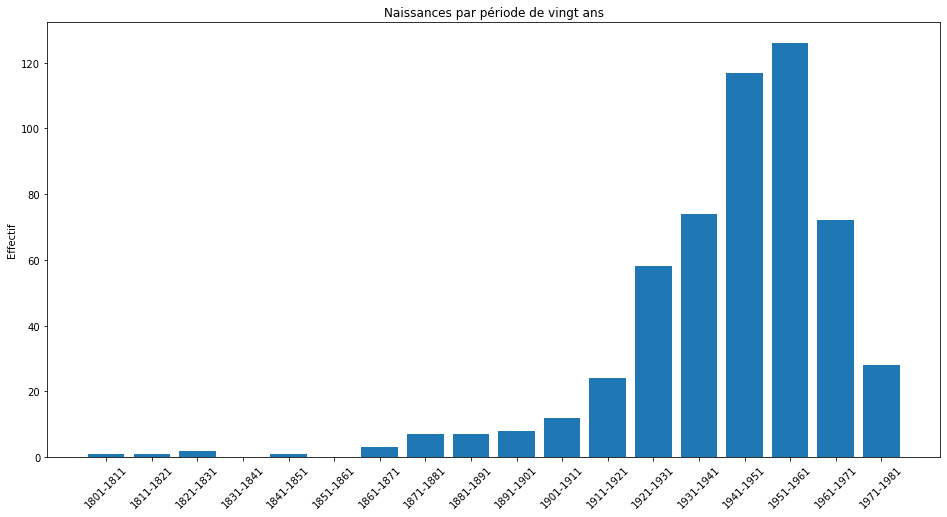

In [458]:
# Distribution par période de 10 ans de la population délimitée

objects = [l for l in gb_decades.index]
eff = [l for l in gb_decades]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingt ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()
